In [1]:
import pandas as pd

In [2]:
import numpy as np

In [25]:
import matplotlib.pyplot as plt

In [4]:
from matplotlib import pyplot

In [5]:
import scipy as sp

In [6]:
import sklearn

In [44]:
import csv

In [7]:
from xgboost import XGBClassifier

In [371]:
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier

In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

In [10]:
filename = 'events.csv'

In [11]:
events = pd.read_csv(filename)

In [105]:
info = pd.read_csv('ginf.csv')

In [111]:
shots.head(3)

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,player,player2,player_in,player_out,shot_place,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,country,date
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,mladen petric,gokhan tore,NaN,NaN,6.0,2.0,0,9.0,2.0,1,1.0,0,germany,2011-08-05
11,UFot0hit/,UFot0hit12,12,14,Attempt missed. Shinji Kagawa (Borussia Dortmu...,1,12.0,1,Borussia Dortmund,Hamburg SV,shinji kagawa,mario gotze,NaN,NaN,13.0,2.0,0,15.0,1.0,1,1.0,0,germany,2011-08-05
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,kevin grosskreutz,mario gotze,NaN,NaN,4.0,1.0,1,9.0,2.0,1,1.0,0,germany,2011-08-05


In [12]:
events.shape

(941009, 22)

In [109]:
events = events.merge(info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')

In [231]:
extract_year = lambda x: datetime.strptime(x, "%Y-%m-%d").year

In [232]:
events['year'] = [extract_year(x) for key, x in enumerate(events['date'])]

In [233]:
shots = events[events.event_type==1]

### Data Exploration

In [234]:
pie = shots[['shot_outcome', 'id_event']].groupby('shot_outcome').count().reset_index().rename(columns={'id_event': 'count'})

In [235]:
pie.shot_outcome = pie.shot_outcome.astype(int)

In [236]:
pie.shot_outcome = pie.shot_outcome.replace({1: 'On Target', 2: 'Off Target', 3: 'Blocked', 4: 'Hit the Bar'})

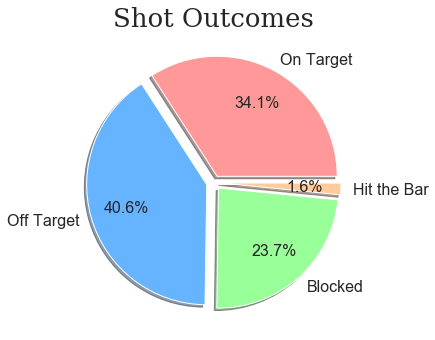

In [304]:
fig, ax = plt.subplots(figsize=[6,6])
labels = pie['shot_outcome']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=pie['count'], autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
       textprops=dict(fontsize=16))
plt.title("Shot Outcomes", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

In [238]:
bar = shots[['shot_place', 'id_event']].groupby('shot_place').count().reset_index().rename(columns={'id_event': 'count'})

In [240]:
bar.shot_place = bar.shot_place.astype(int)

In [241]:
bar.shot_place = bar.shot_place.replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                                        5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                                        9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                                        12: 'Top left corner', 13: 'Top right corner'})

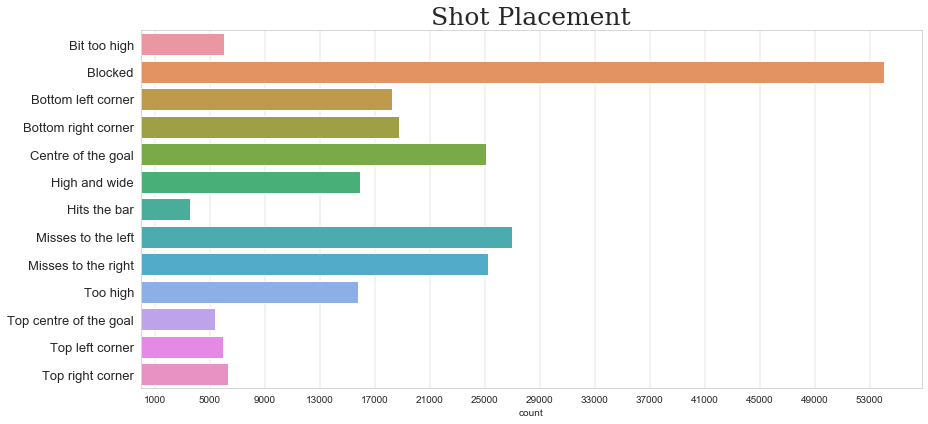

In [305]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[13,6])
labels = bar['shot_place']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=bar['count'], y=labels)
ax.set_yticklabels(labels, size = 13)
ax.set_xticks(np.arange(1000,57000,4000))
ax.set_ylabel(ylabel='')
plt.title("Shot Placement", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

In [296]:
goals  = shots[['is_goal', 'id_event', 'country']].groupby(['is_goal', 'country']).count().reset_index().rename(columns={'id_event': 'count'})

In [297]:
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [298]:
goals['percentage']=0
for i in range(len(goals)):
    for country in goals.country.unique():
        if goals.iloc[i,goals.columns.get_loc("country")]==country:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.country==country]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

In [299]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y+2, value, ha="center", fontsize=14) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

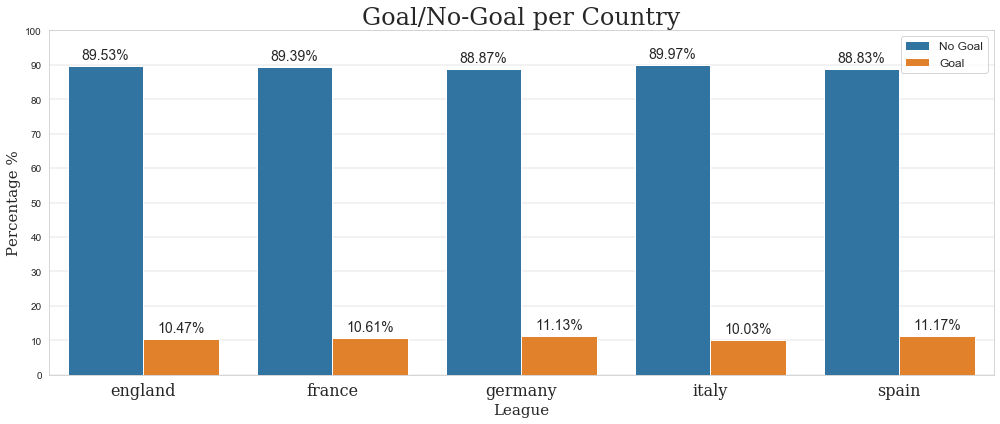

In [309]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='country')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='League', fontsize=15, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Country", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

In [311]:
goals  = shots[['is_goal', 'id_event', 'year']].groupby(['is_goal', 'year']).count().reset_index().rename(columns={'id_event': 'count'})

In [312]:
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [313]:
goals['percentage']=0
for i in range(len(goals)):
    for year in goals.year.unique():
        if goals.iloc[i,goals.columns.get_loc("year")]==year:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.year==year]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

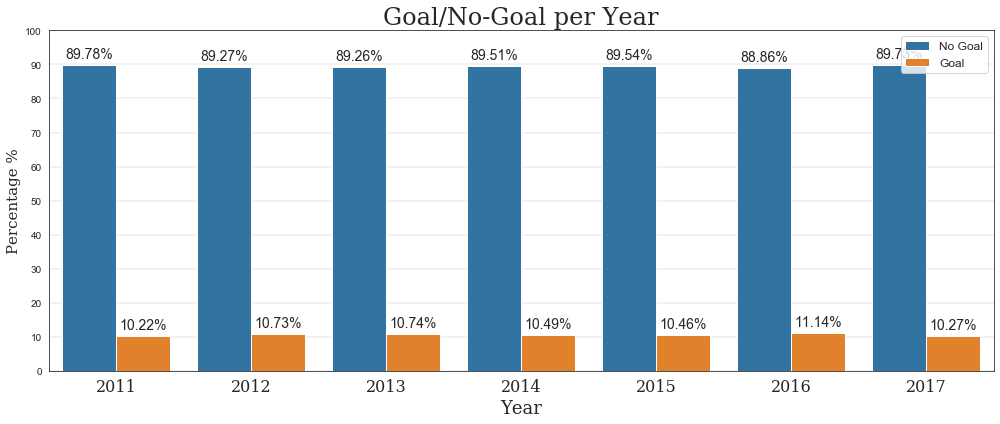

In [314]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='year')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='Year', fontsize=18, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Year", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

### Predicting xG of each shot

#### Preparing data for input

In [320]:
shots.iloc[:,-8:-3]

,location,bodypart,assist_method,situation,fast_break
0,9.0,2.0,1,1.0,0
11,15.0,1.0,1,1.0,0
13,9.0,2.0,1,1.0,0
14,15.0,1.0,0,1.0,0
17,15.0,1.0,0,1.0,0
...,...,...,...,...,...
940983,15.0,1.0,0,1.0,0
940991,15.0,1.0,1,1.0,0
940992,9.0,1.0,1,1.0,0
940993,15.0,1.0,1,1.0,0


In [397]:
dummies = shots.iloc[:,-8:-3]

In [398]:
data = pd.get_dummies(shots.iloc[:,-8:-3], columns=['location', 'bodypart','assist_method', 'situation'])

In [399]:
data.columns = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right', 'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range', 'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header', 'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']

In [337]:
data[data['not_recorded']==1]['is_goal'].sum() / data['not_recorded'].sum()

0.9917241379310345

In [341]:
data = data[data['not_recorded'] != 1]
data.drop('not_recorded', axis=1, inplace=True)

In [387]:
data['fast_breakX_assist_pass'] = data['fast_break'] * data['assist_pass']
data['fast_breakX_loc_centre'] = data['fast_break'] * data['loc_centre_box']
data['headerX_close_range'] = data['header'] * data['close_range']
data['headerXheader'] = data['header'] * data['assist_header']

In [400]:
data['is_goal'] = shots['is_goal']

In [401]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

In [402]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [403]:
X_test.head()

,fast_break,loc_centre_box,loc_diff_angle_lr,diff_angle_left,diff_angle_right,left_side_box,left_side_6ybox,right_side_box,right_side_6ybox,close_range,penalty,outside_box,long_range,more_35y,more_40y,not_recorded,right_foot,left_foot,header,no_assist,assist_pass,assist_cross,assist_header,assist_through_ball,open_play,set_piece,corner,free_kick
851561,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
744702,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
661032,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0
195074,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
742812,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0


In [404]:
len(X_train.columns)

28

#### XGB Classifier

In [405]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def evaluate_model(params): 
    model = GradientBoostingClassifier(
                        learning_rate=params['learning_rate'],
                        min_samples_leaf=params['min_samples_leaf'],
                        max_depth = params['max_depth'],
                        max_features = params['max_features']
                        )

    model.fit(X_train, y_train)
    return {
        'learning_rate': params['learning_rate'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_depth': params['max_depth'],
        'max_features': params['max_features'],
        'train_ROCAUC': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        'test_ROCAUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        'recall': recall_score(y_test, model.predict(X_test)),
        'precision': precision_score(y_test, model.predict(X_test)),
        'f1_score': f1_score(y_test, model.predict(X_test)),
        'train_accuracy': model.score(X_train, y_train),
        'test_accuracy': model.score(X_test, y_test),
    }

def objective(params):
    res = evaluate_model(params)
    
    res['loss'] = - res['test_ROCAUC'] # Esta loss es la que hyperopt intenta minimizar
    res['status'] = STATUS_OK # Asi le decimos a hyperopt que el experimento salio bien
    return res 

hyperparameter_space = {
        'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(15, 200)),
        'max_depth': hp.choice('max_depth', range(2, 20)),
        'max_features': hp.choice('max_features', range(3, 27))
}

In [406]:
trials = Trials()
fmin(
    objective,
    space=hyperparameter_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
);

100%|███████████████████████████████████████████████| 50/50 [13:32<00:00, 16.25s/trial, best loss: -0.8184640898334765]


In [407]:
experiment_results = pd.DataFrame(trials.results)
experiment_results.sort_values(by='loss').head(8)

,learning_rate,min_samples_leaf,max_depth,max_features,train_ROCAUC,test_ROCAUC,recall,precision,f1_score,train_accuracy,test_accuracy,loss,status
24,0.115526,126,6,12,0.818178,0.818464,0.266942,0.715022,0.388750,0.910383,0.911159,-0.818464,ok
35,0.092182,130,6,20,0.818007,0.818409,0.266804,0.715972,0.388744,0.910389,0.911203,-0.818409,ok
41,0.090250,44,7,14,0.818635,0.818407,0.266392,0.714865,0.388143,0.910446,0.911116,-0.818407,ok
31,0.132467,76,6,19,0.818649,0.818313,0.266942,0.715285,0.388789,0.910389,0.911174,-0.818313,ok
32,0.162356,76,6,19,0.818773,0.818299,0.266667,0.715867,0.388583,0.910433,0.911188,-0.818299,ok
22,0.123212,190,9,12,0.818452,0.818271,0.266117,0.715976,0.388015,0.910315,0.911159,-0.818271,ok
21,0.123100,165,9,12,0.818650,0.818191,0.265704,0.716722,0.387686,0.910377,0.911174,-0.818191,ok
45,0.102341,158,8,13,0.818456,0.818190,0.266392,0.717246,0.388494,0.910383,0.911247,-0.818190,ok


In [410]:
model = GradientBoostingClassifier(
                        learning_rate=0.115526,
                        min_samples_leaf=126,
                        max_depth = 6,
                        max_features = 12
                        )
model.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.115526, loss='deviance', max_depth=6,
                           max_features=12, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=126, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [414]:
accuracy = model.score(X_test, y_test)
print('The accuracy of classifying whether a shot is goal or not is {}%.'.format(round(accuracy,2)*100))

The accuracy of classifying whether a shot is goal or not is 91.0%.


In [568]:
y_pred = classifier.predict_proba(X_test)

In [569]:
predict = classifier.predict(X_test)

In [570]:
y_total = y_train.count()
y_positive = y_train.sum()

print('The training set contains {} examples of which {} are positives.'.format(y_total, y_positive))


The training set contains 147995 examples of which 14907 are positives.


In [571]:
auc_roc = roc_auc_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-ROC of {}.'.format(auc_roc))
print('This can be tricky because the dataset is not balanced (any given shot has much less probability of not being a goal than being one)')

Our classifier obtains an AUC-ROC of 0.8051573692925997.
This can be tricky because the dataset is not balanced (any given shot has much less probability of not being a goal than being one)


In [572]:
auc_pr_baseline = y_positive / y_total
print('The baseline performance for AUC-PR is {}.'.format(auc_pr_baseline))
print('This is what we would get by random guessing')

The baseline performance for AUC-PR is 0.1007263758910774.
This is what we would get by random guessing


In [573]:
auc_pr = average_precision_score(y_test, y_pred[:, 1])

print('Our classifier obtains an AUC-PR of {}.'.format(auc_pr))

Our classifier obtains an AUC-PR of 0.409118021123515.


In [209]:
MSE = sklearn.metrics.mean_squared_error(y_test, y_pred[:,1])
print('Our classifier obtains a MSE of {}.'.format(MSE))

Our classifier obtains a MSE of 0.07250601515320562.


In [210]:
print(confusion_matrix(y_test,predict))

[[70820   874]
 [ 6265  2239]]


In [211]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.72      0.26      0.39      8504

   micro avg       0.91      0.91      0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



In [574]:
print(cohen_kappa_score(y_test,predict))

0.2883434076269319


In [213]:
predictions = X_test.copy()
predictions['true_goals'] = y_test
predictions['expected_goals'] = y_pred[:,1]
predictions['difference'] = predictions['expected_goals'] - predictions['true_goals']
predictions = predictions.iloc[:,28:31]

In [214]:
predictions.head()

,true_goals,expected_goals,difference
851561,0,0.174825,0.174825
744702,1,0.164725,-0.835275
661032,0,0.022478,0.022478
195074,0,0.174825,0.174825
742812,0,0.027675,0.027675


#### Lasso Regression

In [146]:
from sklearn.linear_model import Lasso

In [147]:
lasso_model = Lasso(alpha=0.0001, max_iter=1000000)
lasso_model.fit(X_train, y_train)

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [148]:
lasso_model.score(X_train, y_train)

0.18171017054665106

In [149]:
lasso_model.score(X_test, y_test)

0.18660429877787466

In [150]:
coefficients = pd.Series(lasso_model.coef_, X_train.columns)
coefficients

fast_break             0.238697
loc_centre_box         0.115372
loc_diff_angle_lr     -0.019059
diff_angle_left        0.000000
diff_angle_right       0.000000
left_side_box         -0.010053
left_side_6ybox        0.155559
right_side_box        -0.007666
right_side_6ybox       0.159475
close_range            0.457041
penalty                0.614123
outside_box           -0.041297
long_range            -0.038803
more_35y              -0.042128
more_40y              -0.000000
right_foot             0.003985
left_foot              0.000000
header                -0.068617
no_assist             -0.000000
assist_pass            0.004461
assist_cross          -0.036774
assist_header         -0.013758
assist_through_ball    0.125472
open_play             -0.041062
set_piece              0.037339
corner                 0.000031
free_kick             -0.057591
dtype: float64

In [101]:
y_pred = lasso_model.predict(X_test)
y_pred

array([0.02452603, 0.06741468, 0.48417849, ..., 0.06620021, 0.14336318,
       0.02118757])

In [102]:
auc_pr = average_precision_score(y_test, y_pred)

print('Our classifier obtains an AUC-PR of {}.'.format(auc_pr))

Our classifier obtains an AUC-PR of 0.4575219378547048.


In [281]:
predictions_lasso = X_test.copy()
predictions_lasso['true_goals'] = y_test
predictions_lasso['predicted_goals'] = y_predict

C:\Users\Gabriel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Gabriel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [282]:
predictions_lasso

,"(1.0, 3.0)","(1.0, 6.0)","(1.0, 7.0)","(1.0, 8.0)","(1.0, 9.0)","(1.0, 10.0)","(1.0, 11.0)","(1.0, 12.0)","(1.0, 13.0)","(1.0, 14.0)",...,"(3.0, 8.0)","(3.0, 9.0)","(3.0, 10.0)","(3.0, 11.0)","(3.0, 12.0)","(3.0, 13.0)","(3.0, 15.0)","(3.0, 17.0)",true_goals,predicted_goals
14986,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.616771
8247,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.608590
7940,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.764653
1157,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.872584
16034,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.040411
2140,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.840993
3918,3.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.696756
2918,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.708117
10378,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.646334
3093,2.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.176839


#### Neural Network

In [355]:
mlp = MLPClassifier(random_state=0, hidden_layer_sizes=(28,28,28,28), max_iter=2000, activation='relu')

In [356]:
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(28, 28, 28, 28), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [357]:
mlp.score(X_train, y_train)

0.9104856415799969

In [358]:
mlp.score(X_test, y_test)

0.9110077558043842

In [359]:
accuracy = mlp.score(X_test, y_test)
print('The accuracy of classifying whether a shot is goal or not is {}.'.format(accuracy))

The accuracy of classifying whether a shot is goal or not is 0.9110077558043842.


In [360]:
y_pred = mlp.predict_proba(X_test)
predict = mlp.predict(X_test)

In [361]:
y_total = y_train.count()
y_positive = y_train.sum()

print('The training set contains {} examples of which {} are positives.'.format(y_total, y_positive))


The training set contains 148937 examples of which 15937 are positives.


In [362]:
auc_roc = roc_auc_score(y_test, y_pred[:,1])

print('Our classifier obtains an AUC-ROC of {}.'.format(auc_roc))
print('This can be tricky because the dataset is not balanced (any given shot has much less probability of not being a goal than being one)')

Our classifier obtains an AUC-ROC of 0.8188988601236451.
This can be tricky because the dataset is not balanced (any given shot has much less probability of not being a goal than being one)


In [363]:
auc_pr_baseline = y_positive / y_total
print('The baseline performance for AUC-PR is {}.'.format(auc_pr_baseline))
print('This is what we would get by random guessing')

The baseline performance for AUC-PR is 0.10700497525799499.
This is what we would get by random guessing


In [364]:
auc_pr = average_precision_score(y_test, y_pred[:,1])

print('Our classifier obtains an AUC-PR of {}.'.format(auc_pr))

Our classifier obtains an AUC-PR of 0.4741463599616166.


In [365]:
MSE = sklearn.metrics.mean_squared_error(y_test, y_pred[:,1])
print('Our classifier obtains a MSE of {}.'.format(MSE))

Our classifier obtains a MSE of 0.07260425306393019.


In [366]:
print(confusion_matrix(y_test,predict))

[[70771   923]
 [ 6214  2290]]


In [367]:
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.71      0.27      0.39      8504

   micro avg       0.91      0.91      0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



In [368]:
print(cohen_kappa_score(y_test,predict))

0.35327501171362763


In [369]:
predictions = X_test.copy()
predictions['true_goals'] = y_test
predictions['expected_goals'] = y_pred[:,1]
predictions['difference'] = predictions['expected_goals'] - predictions['true_goals']
predictions = predictions.iloc[:,28:31]

In [340]:
predictions.head()

,true_goals,expected_goals,difference
851561,0,0.181754,0.181754
744702,1,0.159302,-0.840698
661032,0,0.019701,0.019701
195074,0,0.181754,0.181754
742812,0,0.026594,0.026594


### Adding expected goals info to the original dataset!

In [370]:
ypred2 = mlp.predict_proba(X_train)

In [372]:
predictions_train = X_train.copy()
predictions_train['true_goals'] = y_train
predictions_train['expected_goals'] = ypred2[:,1]
predictions_train['difference'] = predictions_train['expected_goals'] - predictions_train['true_goals']
predictions_train = predictions_train.iloc[:,28:31]

In [389]:
all_predictions = pd.concat([predictions, predictions_train], axis=0)

In [391]:
events2 = pd.concat([events, all_predictions], axis=1)

In [392]:
shots2 = events2[events2.event_type==1]

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,true_goals,expected_goals,difference
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,2.0,0,9.0,2.0,1,1.0,0,0.0,0.047499,0.047499
11,UFot0hit/,UFot0hit12,12,14,Attempt missed. Shinji Kagawa (Borussia Dortmu...,1,12.0,1,Borussia Dortmund,Hamburg SV,...,2.0,0,15.0,1.0,1,1.0,0,0.0,0.033273,0.033273
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,...,1.0,1,9.0,2.0,1,1.0,0,1.0,0.047499,-0.952501
14,UFot0hit/,UFot0hit15,15,19,Attempt blocked. Mats Hummels (Borussia Dortmu...,1,NaN,1,Borussia Dortmund,Hamburg SV,...,3.0,0,15.0,1.0,0,1.0,0,0.0,0.026345,0.026345
17,UFot0hit/,UFot0hit18,18,20,Attempt blocked. Tomas Rincon (Hamburg) right ...,1,NaN,2,Hamburg SV,Borussia Dortmund,...,3.0,0,15.0,1.0,0,1.0,0,0.0,0.026345,0.026345


## Using XG to conclude things

### xG Players Analysis

In [466]:
xG_players = shots2[['player', 'event_type', 'true_goals', 'expected_goals', 'difference']].groupby('player').sum()

In [467]:
xG_players.columns = ['n_shots', 'goals_scored', 'expected_goals', 'difference']

In [425]:
xG_players[['goals_scored', 'expected_goals']].corr()

,goals_scored,expected_goals
goals_scored,1.00000,0.97665
expected_goals,0.97665,1.00000


In [419]:
xG_players.sort_values(['difference', 'goals_scored'])

,#shots,goals_scored,expected_goals,difference
player,,,,
lionel messi,914,205.0,147.785301,-57.214699
luis suarez,433,96.0,66.885136,-29.114864
zlatan ibrahimovic,774,153.0,124.539731,-28.460269
gonzalo higuain,552,118.0,89.582126,-28.417874
cristiano ronaldo,1190,198.0,172.517022,-25.482978
robert lewandowski,633,124.0,99.958186,-24.041814
alexandre lacazette,391,88.0,65.477343,-22.522657
antoine griezmann,493,80.0,60.674942,-19.325058
alexis sanchez,445,80.0,60.690420,-19.309580


In [427]:
xG_players.sort_values(['expected_goals', 'goals_scored'], ascending=False)

,#shots,goals_scored,expected_goals,difference
player,,,,
cristiano ronaldo,1190,198.0,172.517022,-25.482978
lionel messi,914,205.0,147.785301,-57.214699
zlatan ibrahimovic,774,153.0,124.539731,-28.460269
edinson cavani,623,121.0,118.256201,-2.743799
robert lewandowski,633,124.0,99.958186,-24.041814
pierreemerick aubameyang,580,100.0,91.229665,-8.770335
gonzalo higuain,552,118.0,89.582126,-28.417874
antonio di natale,515,76.0,79.711294,3.711294
diego costa,410,93.0,75.104347,-17.895653


#### Worst shooting-decision players
###### By calculating a "xG / #shots" ratio, we can determine which players make the worst shooting decisions. That is, that they tend to take shots that are not likely to end up in goals

In [468]:
xG_players['xG_per_shot_ratio'] = xG_players['expected_goals'] / xG_players['n_shots']

In [473]:
xG_players[xG_players.n_shots>100].sort_values(['xG_per_shot_ratio', 'goals_scored'])

,n_shots,goals_scored,expected_goals,difference,xG_per_shot_ratio
player,,,,,
tom huddlestone,108,2.0,3.801665,1.801665,0.035201
gokhan inler,185,9.0,7.333342,-1.666658,0.039640
florent balmont,168,5.0,7.122417,2.122417,0.042395
ivan radovanovic,161,2.0,7.569230,5.569230,0.047014
saphir taider,102,4.0,4.932113,0.932113,0.048354
ruben rochina,179,12.0,8.727522,-3.272478,0.048757
daniel baier,177,5.0,8.670070,3.670070,0.048983
michael pereira,101,3.0,4.961315,1.961315,0.049122
marco estrada,106,6.0,5.324807,-0.675193,0.050234


#### Headers

In [432]:
headers = events2[(events2.event_type==1) & (events2.bodypart==3)]

In [435]:
headers_players = headers[['player', 'event_type', 'true_goals', 'expected_goals', 'difference']].groupby('player').sum()

In [436]:
headers_players.columns = ['n_headers', 'goals_scored', 'expected_goals', 'difference']

In [437]:
headers_players[['goals_scored', 'expected_goals']].corr()

,goals_scored,expected_goals
goals_scored,1.000000,0.881481
expected_goals,0.881481,1.000000


In [438]:
headers_players.sort_values(['difference', 'goals_scored'])

,#headers,goals_scored,expected_goals,difference
player,,,,
cristiano ronaldo,159,36.0,19.978661,-16.021339
mario mandzukic,124,28.0,14.458362,-13.541638
fernando llorente,141,25.0,15.727760,-9.272240
sloan privat,86,17.0,9.956783,-7.043217
pierreemerick aubameyang,59,14.0,7.339879,-6.660121
anthony modeste,104,17.0,10.829834,-6.170166
zlatan ibrahimovic,91,17.0,10.911163,-6.088837
michail antonio,32,12.0,5.916832,-6.083168
gareth bale,73,14.0,7.938579,-6.061421


#### Left Foot

In [439]:
left_foot = events2[(events2.event_type==1) & (events2.bodypart==2)]

In [440]:
left_foot_players = left_foot[['player', 'event_type', 'true_goals', 'expected_goals', 'difference']].groupby('player').sum()

In [441]:
left_foot_players.columns = ['n_left_foot_shots', 'goals_scored', 'expected_goals', 'difference']

In [442]:
left_foot_players[['goals_scored', 'expected_goals']].corr()

,goals_scored,expected_goals
goals_scored,1.000000,0.965645
expected_goals,0.965645,1.000000


In [443]:
left_foot_players.sort_values(['difference', 'goals_scored'])

,#left_foot_shots,goals_scored,expected_goals,difference
player,,,,
lionel messi,752,167.0,122.275613,-44.724387
antoine griezmann,345,58.0,42.553398,-15.446602
iago falque,132,23.0,13.516637,-9.483363
arjen robben,296,42.0,32.521805,-9.478195
franck ribery,57,16.0,6.669528,-9.330472
mohamed salah,129,23.0,13.753025,-9.246975
iago aspas,180,34.0,25.676872,-8.323128
gareth bale,195,30.0,22.327069,-7.672931
mauro icardi,47,17.0,9.463369,-7.536631


In [452]:
left_foot_players.loc['cristiano ronaldo']

#left_foot_shots    237.000000
goals_scored         32.000000
expected_goals       29.223878
difference           -2.776122
Name: cristiano ronaldo, dtype: float64

#### Right Foot

In [453]:
right_foot = events2[(events2.event_type==1) & (events2.bodypart==1)]

In [454]:
right_foot_players = right_foot[['player', 'event_type', 'true_goals', 'expected_goals', 'difference']].groupby('player').sum()

In [455]:
right_foot_players.columns = ['n_right_foot_shots', 'goals_scored', 'expected_goals', 'difference']

In [456]:
right_foot_players[['goals_scored', 'expected_goals']].corr()

,goals_scored,expected_goals
goals_scored,1.000000,0.974236
expected_goals,0.974236,1.000000


In [457]:
right_foot_players.sort_values(['difference', 'goals_scored'])

,#right_foot_shots,goals_scored,expected_goals,difference
player,,,,
luis suarez,289,69.0,45.599689,-23.400311
gonzalo higuain,362,86.0,63.913154,-22.086846
alexandre lacazette,270,70.0,50.868442,-19.131558
robert lewandowski,378,84.0,68.662980,-15.337020
zlatan ibrahimovic,554,111.0,96.102880,-14.897120
alexis sanchez,352,62.0,47.829188,-14.170812
eden hazard,248,50.0,37.395238,-12.604762
karim benzema,270,54.0,41.413428,-12.586572
carlos tevez,181,33.0,21.269521,-11.730479


#### Outside the Box Shooters

In [490]:
outside_box = shots2[(shots2.location==15)]

In [491]:
outbox_players = outside_box[['player', 'event_type', 'true_goals', 'expected_goals', 'difference']].groupby('player').sum()

In [492]:
outbox_players.columns = ['n_outside_box_shots', 'goals_scored', 'expected_goals', 'difference']

In [493]:
outbox_players[['goals_scored', 'expected_goals']].corr()

,goals_scored,expected_goals
goals_scored,1.000000,0.786699
expected_goals,0.786699,1.000000


In [495]:
outbox_players.sort_values(['difference', 'goals_scored'])

,n_outside_box_shots,goals_scored,expected_goals,difference
player,,,,
lionel messi,304,16.0,6.958267,-9.041733
paul pogba,226,14.0,6.868845,-7.131155
gonzalo higuain,127,11.0,4.513068,-6.486932
james rodriguez,105,9.0,2.635160,-6.364840
yaya toure,128,10.0,3.964334,-6.035666
zlatan ibrahimovic,261,14.0,8.150821,-5.849179
alexandre lacazette,100,9.0,3.391386,-5.608614
blerim dzemaili,140,10.0,4.464851,-5.535149
sergio aguero,90,9.0,3.575988,-5.424012


#### Best Passing Contributors to xG
##### By looking at the player who made the pass/cross that came prior to the shot, we can evaluate how much xG a player created from his passing.

In [540]:
passes_and_throughballs = pd.concat([shots2[shots2.assist_method==1], shots2[shots2.assist_method==4]])

In [545]:
assisting_players = passes_and_throughballs[['player2', 'event_type', 'true_goals', 'expected_goals', 'difference']].groupby('player2').sum()

In [546]:
assisting_players['xGoals_per_pass'] = assisting_players['expected_goals'] / assisting_players['event_type']

In [547]:
assisting_players.columns = ['n_passes', 'goals_scored_from_passes', 'xGoals_from_passes', 'difference', 'xGoals_per_pass']

In [548]:
assisting_players.sort_values(['difference'], ascending=False)

,n_passes,goals_scored_from_passes,xGoals_from_passes,difference,xGoals_per_pass
player2,,,,,
joan verdu,134,7.0,15.435855,8.435855,0.115193
luca cigarini,164,6.0,13.924280,7.924280,0.084904
philippe coutinho,177,13.0,20.679299,7.679299,0.116832
xabi prieto,152,6.0,13.635634,7.635634,0.089708
alejandro gomez,137,5.0,12.352582,7.352582,0.090165
antonio di natale,136,7.0,14.133843,7.133843,0.103925
victor ibarbo,116,6.0,12.998082,6.998082,0.112052
eden hazard,338,27.0,33.592639,6.592639,0.099387
nolito,179,18.0,24.529997,6.529997,0.137039


In [549]:
assisting_players[assisting_players.n_passes > 50].sort_values(['xGoals_per_pass'], ascending=False)

,n_passes,goals_scored_from_passes,xGoals_from_passes,difference,xGoals_per_pass
player2,,,,,
filip kostic,57,6.0,11.113278,5.113278,0.194970
aritz aduriz,63,15.0,11.060086,-3.939914,0.175557
luis suarez,185,40.0,31.293564,-8.706436,0.169154
gareth bale,109,21.0,17.826142,-3.173858,0.163543
haris seferovic,71,10.0,11.366562,1.366562,0.160092
angel di maria,211,43.0,33.287330,-9.712670,0.157760
jefferson montero,51,7.0,7.982292,0.982292,0.156516
raul garcia,90,16.0,13.996841,-2.003159,0.155520
lionel messi,350,68.0,53.779269,-14.220731,0.153655


#### Best Crossers

In [522]:
crosses = shots2[shots2.assist_method==2]

In [523]:
crosses_players = shots2[['player2', 'event_type', 'true_goals', 'expected_goals', 'difference']].groupby('player2').sum()

In [524]:
crosses_players.columns = ['n_crosses', 'goals_scored_from_crosses', 'xGoals_from_crosses', 'difference']

In [525]:
crosses_players['xGoals_per_cross'] = crosses_players['xGoals_from_crosses'] / crosses_players['n_crosses']

In [526]:
crosses_players.columns = ['n_crosses', 'goals_scored_from_crosses', 'xGoals_from_crosses', 'difference', 'xGoals_per_cross']

In [550]:
crosses_players.sort_values(['difference'], ascending=False)

,n_crosses,goals_scored_from_crosses,xGoals_from_crosses,difference,xGoals_per_cross
player2,,,,,
johannes geis,232,12.0,24.591885,12.591885,0.106000
willian,230,13.0,24.713047,11.713047,0.107448
joan verdu,192,10.0,21.511608,11.511608,0.112040
pascal gross,139,5.0,15.668331,10.668331,0.112722
luca cigarini,278,18.0,27.916344,9.916344,0.100419
filip kostic,135,12.0,21.516195,9.516195,0.159379
ryad boudebouz,416,34.0,43.468857,9.468857,0.104492
ever banega,223,16.0,25.390751,9.390751,0.113860
ezequiel lavezzi,161,11.0,20.351468,9.351468,0.126407


In [556]:
crosses_players[crosses_players.n_crosses > 50].sort_values(['xGoals_per_cross'], ascending=False)

,n_crosses,goals_scored_from_crosses,xGoals_from_crosses,difference,xGoals_per_cross
player2,,,,,
luis suarez,209,44.0,34.892571,-9.107429,0.166950
lukas podolski,61,10.0,10.158822,0.158822,0.166538
filip kostic,135,12.0,21.516195,9.516195,0.159379
moi gomez,69,14.0,10.855441,-3.144559,0.157325
aritz aduriz,92,18.0,14.387418,-3.612582,0.156385
gareth bale,150,33.0,23.383420,-9.616580,0.155889
bebe,59,8.0,9.185548,1.185548,0.155687
angel di maria,360,69.0,55.107913,-13.892087,0.153078
lionel messi,399,75.0,61.020699,-13.979301,0.152934
